In [2]:
import numpy as np
import time
from IPython import display
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
from JSAnimation import IPython_display
import copy


class my_gridworld_2():
    
    def __init__(self,**args):
                
        ### initialize global containers and variables
        # initialize containers for grid, hazard locations, agent and goal locations, etc.,
        self.grid = []
        self.hazards = []
        self.agent = []
        self.goal = []
        self.training_episodes_history = []

        # initialize global variables e.g., height and width of gridworld, hazard penalty value
        self.width = 0
        self.height = 0
        self.hazard_reward = 0
        self.goal_reward = 0
        self.standard_reward = -1
        
        ### check for optional arguments controlling size of gridworld, number/placement/value of hazards.  If no args given go to default.
        # check if a pre-defined gridworld is desired
        if "world" in args:
            # small demo gridworld
            if args['world'] == 'small demo':
                ### initialize grid, agent, obstacles, etc.,
                self.width = 5
                self.height = 4
                self.grid = np.zeros((self.height,self.width))

                # initialize goal location
                self.goal = [0,self.width-1]     # goal block
                
                # initialize agent location
                self.agent = [0,0]   # initial location agent
                
                # initialize hazard locations
                self.hazards = [[0,3],[1,3],[2,3]]  # impenetrable obstacle locations          
                for i in range(len(self.hazards)): 
                    block = self.hazards[i]
                    self.hazards.append(block)
                    self.grid[block[0]][block[1]] = 1
                                                  
            # small random gridworld
            if args['world'] == 'small random':
                ### initialize locations ###
                # initialize grid, agent, hazards, etc.,
                self.width = 5
                self.height = 5
                self.grid = np.zeros((self.height,self.width))
                            
                # initialize goal location
                self.goal = [0,self.width-1]     # goal block
                
                # initialize agent location
                self.agent = [0,0]   # initial location agent
                
                # initialize random hazards locations
                num_hazards = 15
                self.hazards = []
                inds = np.random.permutation(self.width*self.height)
                inds = inds[:num_hazards]
                k = 0
                for i in range(self.height):
                    for j in range(self.width):
                        if k in inds: 
                            block = [i,j]
                            if block != self.goal and block != self.agent:
                                self.hazards.append(block)
                                self.grid[block[0]][block[1]] = 1
                        k+=1
            
            # initialize a big gridworld with randomly placed hazards.  
            if args["world"] == 'big random':
                ### initialize locations ###
                # initialize grid, agent, hazards, etc.,
                self.width = 20
                self.height = 10
                self.grid = np.zeros((self.height,self.width))

                # initialize goal location
                self.goal = [0,self.width-1]     # goal block
                
                # initialize agent location
                self.agent = [0,0]   # initial location agent
                
                # initialize random hazards locations
                num_hazards = 50
                self.hazards = []
                inds = np.random.permutation(self.width*self.height)
                inds = inds[:num_hazards]
                k = 0
                for i in range(self.height):
                    for j in range(self.width):
                        if k in inds: 
                            block = [i,j]
                            if block != self.goal and block != self.agent:
                                self.hazards.append(block)
                                self.grid[block[0]][block[1]] = 1
                        k+=1
        
            # small maze gridworld                      
            if args["world"] == 'small maze':
                # load in preset hazard locations from csv
                hazards = pd.read_csv('RL_datasets/small_maze.csv',header = None)
                
                ### initialize grid, agent, obstacles, etc.,            
                self.width = 13
                self.height = 11
                self.grid = np.zeros((self.height,self.width))
                
                # initialize goal location
                self.goal = [self.height-2, self.width-1]     # goal block
                
                # initialize agent location
                self.agent = [self.height-2, 0]   # initial location agent
  
                # initialize hazards locations
                for i in range(len(hazards)):
                    block = list(hazards.iloc[i])
                    self.hazards.append(block)
                    self.grid[block[0]][block[1]] = 1
        
            # big maze gridworld                      
            if args["world"] == 'big maze':
                # load in preset hazard locations from csv
                hazards = pd.read_csv('RL_datasets/big_maze.csv',header = None)
                
                ### initialize grid, agent, obstacles, etc.,            
                self.width = 41
                self.height = 15
                self.grid = np.zeros((self.height,self.width))

                # initialize goal location
                self.goal = [self.height-2, self.width-1]     # goal block
                self.grid[self.goal[0]][self.goal[1]] = 2

                # initialize agent location
                self.agent = [self.height-2, 0]   # initial location agent
                
                # initialize hazards locations
                for i in range(len(hazards)):
                    block = list(hazards.iloc[i])
                    self.grid[block[0]][block[1]] = 1
                    
        ### check for hazard penalty value ###
        if "hazard value" in args:
            self.hazard_reward = args['hazard value']
        else:
            self.hazard_reward = max(self.width,self.height)        
        
        ### initialize state index, Q matrix, and action choices ###
        # index states for Q matrix
        self.states = []
        for i in range(self.height):
            for j in range(self.width):
                block = [i,j]
                self.states.append(str(i) + str(j))
        
        # initialize action choices
        self.action_choices = [[-1,0],[1,0],[0,-1],[0,1]]
        
        # initialize Q^* matrix
        self.Q_star = np.zeros((self.width*self.height,len(self.action_choices)))

        ### create custom colormap for gridworld plotting ###
        vmax = 3.0
        self.my_cmap = LinearSegmentedColormap.from_list('mycmap', [(0 / vmax, [0.9,0.9,0.9]),
                                                        (1 / vmax, [1,0.5,0]),
                                                        (2 / vmax, 'lime'),
                                                        (3 / vmax, 'blue')]
                                                        )
        
    ### world coloring function ###
    def color_gridworld(self,ax):
        # copy grid for plotting, add agent and goal location
        p_grid = copy.deepcopy(self.grid)
        p_grid[self.goal[0]][self.goal[1]] = 2   
        p_grid[self.agent[0]][self.agent[1]] = 3   
        
        # plot gridworld
        ax.pcolormesh(p_grid,edgecolors = 'k',linewidth = 0.01,cmap = self.my_cmap)

        # clean up plot
        ax.axis('off')
        ax.set_xlim(-0.1,self.width + 1.1);
        ax.set_ylim(-0.1,self.height + 1.1);        
        
    ## Q-learning function
    def qlearn(self,**args):
        ### set basic parameters controlling training regiment ###
        # default parameters for the qlearning 
        gamma = 0.8                            # short term / long term learning tradeoff param
        num_episodes = 3                     # maximum number of episodes of simulation
        max_steps = 5*self.width*self.height  # maximum number of steps per episode

        # change these default parameters if user requests
        if "gamma" in args:
            gamma = args['gamma']
        if 'training episodes' in args:
            num_episodes = args['training episodes']
        if 'max steps per episode' in args:
            max_steps = args['max steps per episode']    
            
        ### create starting schedule - where agent starts - at beginning of each episode ###
        start_schedule = []  # container for holding starting positions
        
        # create schedule of random starting positions for each episode
        if 'start schedule' not in args or ('start schedule' in args and args['start schedule'] == 'random'):
            for i in range(num_episodes):
                loc = [np.random.randint(self.height),np.random.randint(self.width)]
                start_schedule.append(loc)
                
        # create exhaustive starting schedule - cycle through states sequentially
        if 'start schedule' in args and args['start schedule'] == 'exhaustive':
            i = 0
            while i < num_episodes:
                for j in range(self.width):
                    for k in range(self.height):
                        loc = [j,k]
                        start_schedule.append(loc)
                        i+=1

        ### start main Q-learning loop ###
        self.training_episodes_history = {}
        for n in range(num_episodes):    
            # pick this episode's starting position
            loc = start_schedule[n]
            
            # update Q matrix while loc != goal
            episode_history = []      # container for storing this episode's journey
            episode_history.append(loc)
            for step in range(max_steps):    
                ### if you reach the goal end current episode immediately
                if loc == self.goal:
                    break
                    
                ### choose next action - left = 0, right = 1, up = 2, down = 3 --> if this leads you outside the gridworld you don't move
                k = np.random.randint(len(self.action_choices))  
                loc2 = [sum(x) for x in zip(loc, self.action_choices[k])] 
                ind_old = self.states.index(str(loc[0]) + str(loc[1]))

                # if new state is outside of boundaries of grid world do not move
                if loc2[0] > self.height-1 or loc2[0] < 0 or loc2[1] > self.width-1 or loc2[1] < 0:  
                    loc2 = loc
                
                ### recieve reward     
                # if new state is goal set reward of 0
                if loc2 == self.goal:
                    r_k = self.goal_reward
                elif loc2 in self.hazards:
                    r_k = self.hazard_reward
                else:  # standard non-hazard square
                    r_k = self.standard_reward
                
                ### Update Q function
                ind_new = self.states.index(str(loc2[0]) + str(loc2[1]))
                self.Q_star[ind_old,k] = r_k + gamma*max(self.Q_star[ind_new,:])
                    
                ### update current location of agent to one we just moved too (or stay still if grid world boundary met)
                self.agent = loc2
                loc = loc2
                
                ### update episode history container
                episode_history.append(loc)
                
            ### store this episode's history
            self.training_episodes_history[str(n)] = episode_history
            
        print 'q-learning process complete'
            
    ### animate training episode ###
    def animate_training_episode(self,episodes):
        # initialize figure
        fig = plt.figure(figsize = (10,3))
        axs = []
        for i in range(len(episodes)):
            ax = fig.add_subplot(1,len(episodes),i+1)
            axs.append(ax)
            
        if len(episodes) == 1:
            axs = np.array(axs)

        # make a copy of the original gridworld - set at initialization
        gridworld_orig = self.grid.copy()
        
        # compute maximum length of episodes animated
        max_len = 0
        for key in episodes:
            l = len(self.training_episodes_history[str(key)])
            if l > max_len:
                max_len = l

        # loop over the episode histories and plot the results
        def show_episode(step):
            # loop over subplots and plot current step of each episode history
            artist = fig

            for k in range(len(axs)):
                ax = axs[k]
                
                # take correct episode
                key_num = episodes[k]
                episode_num = episodes[key_num]
                current_episode = self.training_episodes_history[str(episode_num)]
                                
                # define new location of agent
                loc = current_episode[min(step,len(current_episode)-1)]
                self.agent = loc
                
                # color gridworld for this episode and step
                self.color_gridworld(ax)
                ax.set_title('episode = ' + str(episode_num))                
            return artist,
           
        # create animation object
        anim = animation.FuncAnimation(fig, show_episode,frames=min(100,max_len), interval=min(100,max_len), blit=True)
        
        # set frames per second in animation
        IPython_display.anim_to_html(anim,fps = min(100,max_len)/float(5))
    
        return(anim)

q-learning process complete


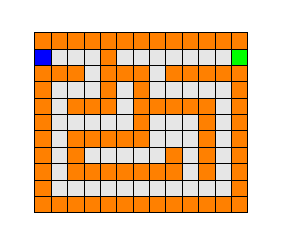

In [ ]:
%matplotlib inline
test = my_gridworld_2(world = 'small maze')
fig1 = plt.figure(figsize = (3,3))
ax1 = fig1.add_subplot(111, aspect='equal')
test.color_gridworld(ax1)
test.qlearn()

In [ ]:
test.animate_training_episode([0,1])